# k-Nearest Neighbors (k-NN)

### Backgrounds

- “Classification is a data mining technique used to predict **group membership** for data instances”
    - Group membership is utilized for the prediction of future datasets

- Origins of K-NN: ‘Nearest Neighbors’ have been used in statistical estimation and pattern recognition already in the beginning of 1970’s

- Different names of K-NN
    - Memory-based reasoning, example-based reasoning
    - Instance-based learning, lazy learning
    
### Definition

- K-Nearest Neighbors (K-NN)
    - to identify k records in the training dataset that are similar to a new record that we wish to classify (Classifies datasets based on their similarity with neighbors)
    - A non-parametric lazy learning algorithm
- “K” stands for # of data items considered for the classification
    - e.g., classification for different k-values
    
### Characteristics

- Data-driven, not model-driven
- Makes no assumptions about the data

- Basic idea
    - For a given record to be classified, **identify nearby records**
    - “Near” means records with similar predictor values X1, X2, … Xp
    - Classify the record as whatever the predominant class is among the nearby records (the “neighbors”)
    
### How to measure “Nearby”?
- The most popular distance measure is Euclidean distance
- Typically, predictor variables are first normalized (= standardized) to put them on comparable scales. Use ‘preprocess()’ from ‘caret’ package to normalize!

### How to choose K?
- k is the number of nearby neighbors to be used to classify the new record
- k=1 means using the single nearest record
- k=5 means using the 5 nearest records

- If K is too small it is sensitive to noise points
- High values of k provide more smoothing, less noise, but may miss local structure
- Larger K works well, But too large K: include majority points from other classes

- Typically choose that value of k **which has lowest error rate in validation data**





## Advantages and Shortcomings of k-NN Algorithms

Advantages
Simple
No assumptions required about Normal distribution, etc.
Effective at capturing complex interactions among variables without having to define a statistical model
Shortcomings
Required size of training set increases exponentially with # of predictors, p
This is because expected distance to nearest neighbor increases with p (with large vector of predictors, all records end up “far away” from each other)
In a large training set, it takes a long time to find distances to all the neighbors and then identify the nearest one(s)
These constitute “curse of dimensionality”
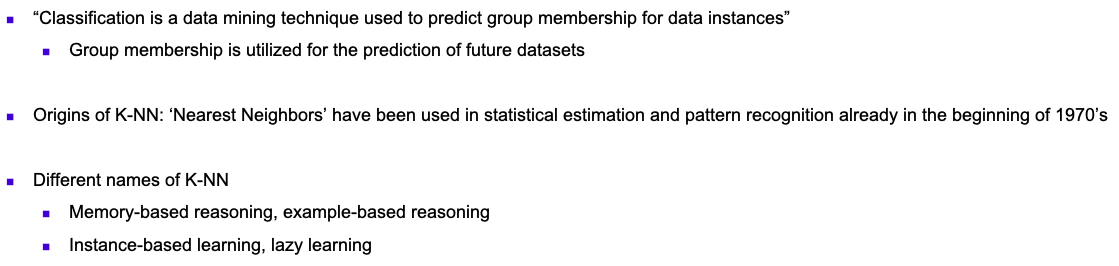

## Example: Riding Mowers
to find a way of classifying families in a city into those likely to purchase a riding mower and those not likely to buy one.

In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import matplotlib.pylab as plt

### Prepare ‘Riding Mowers’ Data

In [4]:
#Load and split data (60% is training data, 40% is validation data)
mower_df = pd.read_csv('RidingMowers.csv')
mower_df['Number'] = mower_df.index + 1
trainData, validData = train_test_split(mower_df, test_size=0.4, random_state=26)

#Make a new household data to test the model
newHousehold = pd.DataFrame([{'Income': 60, 'Lot_Size': 20}])

### Visualize Data using Scatter Plot

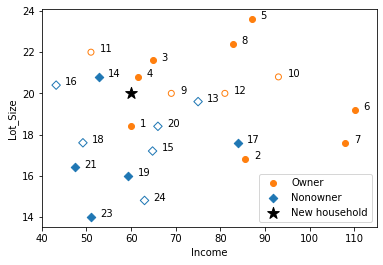

In [5]:
def plotDataset(ax, data, showLabel=True, **kwargs):
    subset = data.loc[data['Ownership']=='Owner']
    ax.scatter(subset.Income, subset.Lot_Size, marker='o',
    label='Owner' if showLabel else None, color='C1', **kwargs)
    subset = data.loc[data['Ownership']=='Nonowner']
    ax.scatter(subset.Income, subset.Lot_Size, marker='D', label='Nonowner' if showLabel else None, color='C0', **kwargs)
    plt.xlabel('Income') # set x-axis label
    plt.ylabel('Lot_Size') # set y-axis label
    for _, row in data.iterrows():
        ax.annotate(row.Number, (row.Income + 2, row.Lot_Size))

fig, ax = plt.subplots()
plotDataset(ax, trainData)
plotDataset(ax, validData, showLabel=False, facecolors='none')
ax.scatter(newHousehold.Income, newHousehold.Lot_Size, marker='*', label='New household', color='black', s=150)
plt.xlabel('Income'); plt.ylabel('Lot_Size')
ax.set_xlim(40, 115)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=4)
plt.show()

### Preprocess Data

In [6]:
##Initialize training, validation, and complete data frames

#Declare standard scaler and learn transformation
predictors = ['Income', 'Number']
scaler = preprocessing.StandardScaler()
scaler.fit(trainData[['Income','Lot_Size']])

#Transform full dataset
mowerNorm = pd.concat([
    pd.DataFrame(
        scaler.transform(mower_df[['Income', 'Lot_Size']]),
        columns=['zIncome', 'zLot_Size']),
    mower_df[['Ownership', 'Number']]], axis=1)
trainNorm = mowerNorm.iloc[trainData.index]
validNorm = mowerNorm.iloc[validData.index]
newHouseholdNorm = pd.DataFrame(
    scaler.transform(newHousehold),
    columns=['zIncome', 'zLot_Size'])


### Run K-NN

In [7]:
#Compute K-NN : Use scikit-learn NearestNeighbors to compute knn

from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=3)
knn.fit(trainNorm.iloc[:, 0:2])
distances, indices = knn.kneighbors(newHouseholdNorm)

trainNorm.iloc[indices[0], :] #indices is a list of lists, only check first element

,zIncome,zLot_Size,Ownership,Number
3,-0.409776,0.743358,Owner,4
13,-0.804953,0.743358,Nonowner,14
0,-0.477910,-0.174908,Owner,1


#### Accuracy of K-NN

In [8]:
#Initialize a data frame
#Split training and validation datsets into x, y
train_X = trainNorm[['zIncome', 'zLot_Size']]
train_y = trainNorm['Ownership']
valid_X = validNorm[['zIncome', 'zLot_Size']]
valid_y = validNorm['Ownership']

#Train kNN classifiers and validate
results = []
for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })
results = pd.DataFrame(results)
print(results)


     k  accuracy
0    1       0.6
1    2       0.7
2    3       0.8
3    4       0.9
4    5       0.7
5    6       0.9
6    7       0.9
7    8       0.9
8    9       0.9
9   10       0.8
10  11       0.8
11  12       0.9
12  13       0.4
13  14       0.4


We choose the k with the best classification performance. We use the training data to classify the records in the validation data, then compute error rates for various choices of k. 

For our example, if we choose k = 1, we will classify in a way that is very sensitive to the local characteristics of the training data. On the other hand, if we choose a large value of k, such as k = 14, we would simply predict the most frequent class in the dataset in all cases. This is a very stable prediction but it completely ignores the
information in the predictors. To find a balance, we examine the accuracy (of predictions in the validation set) that results from different choices of k between 1 and 14. For an even number k, if there is a tie in classifying a household, the tie is broken randomly. **We would choose k = 4, which maximizes our accuracy in the validation set.**

#### Classifying a new household using the “best k” = 4

In [9]:
##running the k-NN algorithm to classify the new household

#Retrain with full dataset
mower_X = mowerNorm[['zIncome', 'zLot_Size']]
mower_y = mowerNorm['Ownership']
knn = KNeighborsClassifier(n_neighbors=4).fit(mower_X, mower_y)

#Predict on new household dataset
distances, indices = knn.kneighbors(newHouseholdNorm)
print(knn.predict(newHouseholdNorm))
print('Distances',distances)
print('Indices', indices)
print(mowerNorm.iloc[indices[0], :])

['Owner']
Distances [[0.31358009 0.40880312 0.44793643 0.61217726]]
Indices [[ 3  8 13  0]]
     zIncome  zLot_Size Ownership  Number
3  -0.409776   0.743358     Owner       4
8  -0.069107   0.437269     Owner       9
13 -0.804953   0.743358  Nonowner      14
0  -0.477910  -0.174908     Owner       1


- Once k is chosen, we rerun the algorithm on the combined training and testing sets in order to generate classifications of new records.

k-NN uses a majority decision rule to classify a new record, where the record is classified
as a member of the majority class of the k neighbors.

In the riding mowers example with k = 4, we found that the four nearest neighbors to the new household (with income = $60,000 and lot size = 20,000 ft2) are households 4, 9, 14, and 1. Since three of these are owners and one is a nonowner, we can estimate for the new household a probability of 0.75 of being an owner (and 0.25 for being a nonowner). Using a simple majority rule is equivalent to setting the cutoff value to 0.5. In Table 7.4, we see
that the software assigned class owner to this record.


As mentioned in Chapter 5, changing the cutoff value affects the confusion matrix (i.e., the
error rates). Hence, in some cases we might want to choose a cutoff other than the default
0.5 for the purpose of maximizing accuracy or for incorporating misclassification costs.